Quadrotor dynamics

In [709]:
import math

import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
import pdb

from simulator import Sim

class Quadrotor():
    def __init__(self):
        self.sim = Sim()

        self.T = np.diag([1.0, -1, -1, -1])
        self.H = np.vstack([np.zeros((1,3)), np.eye(3)])

        # Quadrotor parameters
        self.mass = 0.035  # center mass
        self.g = 9.81  # gravity
        # thrustToTorque = 0.005964552
        self.thrustToTorque = 0.0008  # thrust to torque ratio
        self.el = 0.046/1.414213562  # arm length
        
        self.scale = 65535  # PWM scale
        self.kt = 2.245365e-6*self.scale # thrust coefficient, u is PWM in range [0...1], 0 is no thrust, 1 is max thrust
        self.km = self.kt*self.thrustToTorque # moment coefficient
        self.Jx = self.el**2*(self.mass/4)*2
        self.Jy = self.el**2*(self.mass/4)*2
        self.Jz = self.el**2*self.mass
        self.J = np.array([[self.el**2*(self.mass/4)*2, 0, 0], [0, self.el**2*(self.mass/4)*2, 0], [0, 0, self.el**2*self.mass]])  # inertia
        # Configuration Space
        self.num_states = 12
        self.num_controls = 4

        #  Choose Q and R matrices based on Bryson's rule
        max_dev_x = np.array([0.1, 0.1, 0.1,  0.5, 0.5, 0.05,  0.5, 0.5, 0.5,  0.7, 0.7, 0.2])
        max_dev_u = np.array([0.5, 0.5, 0.5, 0.5])/6
        
        self.Q = np.diag(1./max_dev_x**2)
        self.R = np.diag(1./max_dev_u**2)
        self.A_jac = jacobian(self.quad_dynamics_rk4, 0)  # jacobian wrt x
        self.B_jac = jacobian(self.quad_dynamics_rk4, 1)  # jacobian wrt u

      
    # Quadrotor dynamics -- single rigid body dynamics
    def quad_dynamics(self, x, u, mass,Jx,Jy,Jz):
        '''
        State vector x (12x1):
            x[0] : x-position (vehicle-1 frame, forward)
            x[1] : y-position (vehicle-1 frame, lateral)
            x[2] : z-position (altitude)
            x[3] : x_dot (velocity along x)
            x[4] : y_dot (velocity along y)
            x[5] : z_dot (velocity along z)
            x[6] : φ (roll angle)
            x[7] : θ (pitch angle)
            x[8] : ψ (yaw angle)
            x[9] : p (roll rate)
            x[10]: q (pitch rate)
            x[11]: r (yaw rate)
        '''
        
        Ff,Fr,Fb,Fl = u
        pn,pe = x[0:2]        # Position
        h = x[2]
        u_,v,w = x[3:6]        # Velocity
        phi,theta,psi = x[6:9]   # Euler angles: [phi, theta, psi]
        p,q,r = x[9:12]   # Angular velocity
        F = (Ff+Fr+Fb+Fl)
        # The following matrix maps motor inputs to body torques.
        tau = np.array([self.el*(Fl-Fr),self.el*(Ff-Fb),(Fr+Fl-Ff-Fb)/self.thrustToTorque])
      #  print("F: ",F, "tau: ", tau)
        x_dot,y_dot,z_dot = u_,v,w
        phi_dot,theta_dot,psi_dot = p,q,r

        # u_dot = -np.cos(phi)*np.sin(theta)*F/mass
        # v_dot = np.sin(phi)*F/mass
        w_dot = -(self.g - np.cos(phi)*np.cos(theta)*F/mass)
       
        # p_dot = tau[0] / Jx#self.J[0][0]
        # q_dot = tau[1] / Jy#self.J[1][1]
        # r_dot = tau[2] / Jz#self.J[2][2]

        u_dot =(v*r-w*q) +self.g*np.sin(theta)
        v_dot = (w*p-u_*r) +self.g*np.cos(theta)*np.sin(phi)
        # w_dot = (u_*q-v*p) -self.g*(np.sin(theta)*np.sin(phi)*F/mass)
       
        p_dot = (Jy-Jz)/Jx *q*r +tau[0]/Jx
        q_dot =  (Jz-Jx)/Jy *p*r + tau[1] / Jy#self.J[1][1]
        r_dot = (Jx-Jy)/Jz *q*p + tau[2] / Jz#self.J[2][2]
        print("tau: ", tau)
        print("rdot: ", r_dot)
        return np.hstack([x_dot,y_dot,z_dot,u_dot,v_dot,w_dot,phi_dot,theta_dot,psi_dot,p_dot,q_dot,r_dot])
    
    def get_tau(self,u,el,thrustToTorque):
        Ff,Fr,Fb,Fl = u
        tau = np.array([el*(Fl-Fr),el*(Ff-Fb),(Fr+Fl-Ff-Fb)/thrustToTorque])
        return tau
    def get_linearized_dynamics(self, xg, uhover, mass,Jx,Jy,Jz):
   
        Anp = self.A_jac(xg, uhover, mass,Jx,Jy,Jz)
        Bnp = self.B_jac(xg, uhover, mass,Jx,Jy,Jz)
        self.Anp = Anp
        self.Bnp = Bnp

        return self.Anp, self.Bnp
    
    def get_linear_system(self, Vb, wB, dVb, dwB, F, tau):
        """
        Build the linear system A * [m, Jx, Jy, Jz]^T = b
        from one time instant of Newton-Euler data.
        
        Inputs:
        Vb, wB : 3D arrays for linear velocity (m/s) and angular velocity (rad/s) in body frame
        dVb, dwB : 3D arrays for linear acceleration and angular acceleration in body frame
        F, tau : 3D arrays for net force (N) and torque (N·m) in body frame

        Returns:
        A : shape (6,4)
        b : shape (6,)
        """
        # Cross terms for translational eq
        # a_x, a_y, a_z = [dV^B/dt + w^B x V^B]
        a = dVb + np.cross(wB, Vb)  # shape (3,)
        a2 = dwB + np.cross(wB, wB)
        A = np.zeros((6, 4))
        b = np.zeros((6,1))

        print("a3: ", a[2],"F: ", F[2])
       # print("F: ", F)
        # 1) Translational
        A[0,:] = [ a[0], 0,    0,    0 ]
        A[1,:] = [ a[1], 0,    0,    0 ]
        A[2,:] = [ a[2], 0,    0,    0 ]
        b[0,0] = F[0]
        b[1,0] = F[1]
        b[2,0] = F[2]

        # 2) Rotational
        # For diagonal I => Jx, Jy, Jz. Let p,q,r = wB, dp,dq,dr = dwB
        p,q,r = wB
        dp, dq, dr = dwB
        tau_x, tau_y, tau_z = tau

        # eq for tau_x = Jx*dp + (Jy - Jz)*q*r
        # => row is [0, dp, q*r, -q*r]
        A[3,:] = [ 0, dp, -q*r, q*r ]
        b[3,0] = tau_x

        # eq for tau_y = Jy*dq + (Jz - Jx)*r*p
        # => row is [0, -r*p, dq, r*p]
        A[4,:] = [ 0, r*p, dq, -r*p ]
        b[4,0] = tau_y

        # eq for tau_z = Jz*dr + (Jx - Jy)*p*q
        # => row is [0, p*q, -p*q, dr]
        A[5,:] = [ 0, -p*q, p*q, dr ]
        b[5,0] = tau_z

        
        return A, b
    
    # RK4 integration with zero-order hold on u
    def delta_x_quat(self, x_curr, x_nom):
        # Compute the state deviation
        delta_x = x_curr-x_nom
        return delta_x
    
    def get_hover_goals(self, mass, kt):
        # Hovering state and control input
        self.xg =  np.zeros(self.num_states)
        self.uhover = (mass*self.g/4 )*np.ones(4) # ~each motor thrust to compensate for gravity
        # print("Hovering Initial State and Control")
        # print(self.xg, self.uhover)

        return self.xg, self.uhover
    
  # RK4 integration with zero-order hold on u
    def quad_dynamics_rk4(self, x, u, mass,Jx,Jy,Jz):
        f1 = self.quad_dynamics(x, u, mass,Jx,Jy,Jz)
        f2 = self.quad_dynamics(x + 0.5*self.sim.h*f1, u, mass,Jx,Jy,Jz)
        f3 = self.quad_dynamics(x + 0.5*self.sim.h*f2, u, mass,Jx,Jy,Jz)
        f4 = self.quad_dynamics(x + self.sim.h*f3, u, mass,Jx,Jy,Jz)
        xn = x + (self.sim.h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
        # print("f1", f1,"f2", f2,"f3", f3,"f4", f4)
        # print("xn:",xn)
        return xn


tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdot:  0.0
tau:  [0. 0. 0.]
rdo

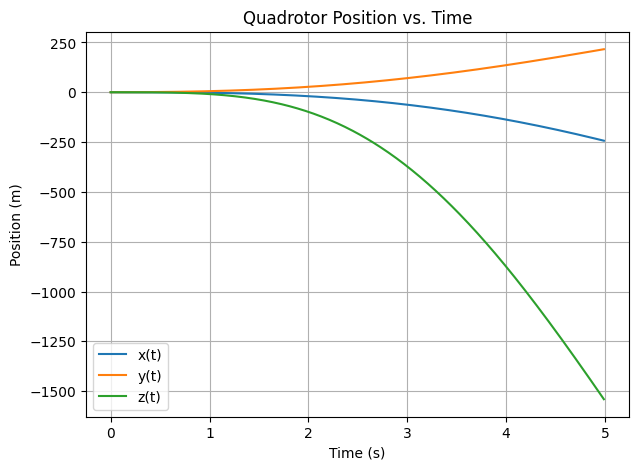

In [702]:
#test only dynamics model 
import matplotlib.pyplot as plt

def test_quad_dynamics():
    quad = Quadrotor()
    dt = 0.01  # Time step (s)
    T = 5.0    # Total simulation time (s)
    n_steps = int(T / dt)
    
    # Initial state (all zeros)
    x = np.random.uniform(0, 0.2, 12)
    
    # Constant thrust input (hovering condition)
    u = (quad.mass * quad.g / 4) * np.ones(4)
    
    # Data storage for plotting
    time_hist = []
    x_hist, y_hist, z_hist = [], [], []
    
    for i in range(n_steps):
        t = i * dt
        time_hist.append(t)
        x_hist.append(x[0])
        y_hist.append(x[1])
        z_hist.append(x[2])
        
        # RK4 integration step
        x = quad.quad_dynamics_rk4(x, u, quad.mass, quad.Jx, quad.Jy, quad.Jz)
    
    # Plot results
    plt.figure(figsize=(7,5))
    plt.plot(time_hist, x_hist, label='x(t)')
    plt.plot(time_hist, y_hist, label='y(t)')
    plt.plot(time_hist, z_hist, label='z(t)')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (m)')
    plt.title('Quadrotor Position vs. Time')
    plt.legend()
    plt.grid(True)
    plt.show()

test_quad_dynamics()


LQR

In [649]:
import math
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian

class LQRController():
    def __init__(self, delta_x_quat):
        self.delta_x_quat = delta_x_quat

    def get_QR_bryson(self):
        max_dev_x = np.array([0.1, 0.1, 0.1,  0.5, 0.5, 0.05,  0.5, 0.5, 0.5,  0.7, 0.7, 0.2])
        max_dev_u = np.array([0.5, 0.5, 0.5, 0.5])/6
        Q = np.diag(1./max_dev_x**2)
        R = np.diag(1./max_dev_u**2)

        return Q, R

    def update_linearized_dynamics (self, Anp, Bnp, Q, R):
        self.Anp = Anp
        self.Bnp = Bnp
        self.Q = Q
        self.R = R

    # Riccati recursion on the linearized dynamics
    def dlqr(self, A, B, Q, R, n_steps = 1000):
        P = Q
        # print("rankB: ",np.linalg.matrix_rank(B))
        for i in range(n_steps):
            K = inv(R + B.T @ P @ B) @ B.T @ P @ A
            P = Q + A.T @ P @ (A - B @ K)
        return K, P

    # Drive the system from initial state to the hovering state using the LQR controller:
    # LQR controller, input is 12x1 state vector
    def compute(self, x_curr, x_nom, u_nom):
        K_lqr, P_lqr = self.dlqr(self.Anp, self.Bnp, self.Q, self.R)
        delta_x = self.delta_x_quat(x_curr, x_nom)
        # print("u_nom: ", u_nom)
        # print("delta x pos: ",delta_x)
        # print("K_lqr @ delta_x", K_lqr @ delta_x)
        return u_nom - K_lqr @ delta_x


estimation methods

In [19]:
import numpy as np
import unittest


class LMS:
    """
    Basic least mean squares (LMS) method.

    This is a gradient method and implements both normalized and unnormalized approaches.
    """

    def __init__(
        self, num_params, theta_hat=None, gain=0.01, normalized=True, bias=1e-6
    ):
        self.n = num_params
        self.gamma = gain
        self.bias = bias
        self.normalized = normalized
        self.theta_hat = (
            theta_hat if theta_hat is not None else np.zeros((num_params, 1))
        )

    def iterate(self, A, b):
        Q = np.ones((self.n, 1)) * self.gamma

        if self.normalized:
            Q /= np.linalg.norm(A, axis=1) ** 2 + self.bias

        K = A @ Q
        self.theta_hat += K @ (b - A @ self.theta_hat)


class RLS:
    """RLS with adaptive forgetting factor (lambda)."""

    def __init__(self, num_params, theta_hat=None, forgetting_factor=0.98, c=1000):
        """
        :param num_params: Number of parameters to estimate.
        :param theta_hat: Initial estimate of parameters, otherwise set to zeros.
        :param forgetting_factor: Forgetting factor (typically referred to as lambda).
        :param c: Constant factor for initial covariance matrix scale.
        """
        self.n = num_params
        self.P = np.eye(num_params) * c
        self.theta_hat = (
            theta_hat if theta_hat is not None else np.zeros((num_params, 1))
        )
        self.lambda_ = forgetting_factor

    def iterate(self, A, b):
        """
        :param A: Jacobian of system w.r.t. parameters.
        :param b: Measurement vector.
        """
        K = (
            self.P
            @ A.T
            @ np.linalg.inv(A @ self.P @ A.T + self.lambda_ * np.eye(A.shape[0]))
        )
        self.theta_hat += K @ (b - A @ self.theta_hat)
        self.P = (self.P - K @ A @ self.P) / self.lambda_
        return self.theta_hat


class AdaptiveLambdaRLS:
    """
    RLS with adaptive forgetting factor (lambda).

        lambda = 1 - alpha / (1 + ||b - A * theta||)

    Adjusts lambda such that forgetting is reduced when parameters are stable and increased when changing.
    """

    def __init__(
        self, num_params, theta_hat=None, forgetting_factor=0.98, alpha=0.01, c=1000
    ):
        """
        :param num_params: Number of parameters to estimate.
        :param theta_hat: Initial estimate of parameters, otherwise set to zeros.
        :param forgetting_factor: Forgetting factor (typically referred to as lambda).
        :param forgetting_adaptation: Tuning factor for adaptive forgetting.
        :param c: Constant factor for initial covariance matrix scale.
        """
        self.n = num_params
        self.P = np.eye(num_params) * c
        self.theta_hat = (
            theta_hat if theta_hat is not None else np.zeros((num_params, 1))
        )
        self.lambda_ = forgetting_factor
        self.alpha = alpha

    def iterate(self, A, b):
        """
        :param A: Jacobian of system w.r.t. parameters.
        :param b: Measurement vector.
        """
        K = (
            self.P
            @ A.T
            @ np.linalg.inv(A @ self.P @ A.T + self.lambda_ * np.eye(A.shape[0]))
        )
        self.theta_hat += K @ (b - A @ self.theta_hat)
        self.P = (self.P - K @ A @ self.P) / self.lambda_
        self.lambda_ = 1 - self.alpha / (1 + np.linalg.norm(b - A @ self.theta_hat))
        return self.theta_hat


class EKF:
    """
    Basic Extended Kalman Filter

    Assumes that the process noise and measurement noise are known, and that their Jacobians are I. Additionally, the process model jacobian is assumed to be I.

    The process model and measurement model are flipped!

    process model x_k is parameters theta
    measurement z_k is state x
    """

    def __init__(
        self, num_params, process_noise, measurement_noise, theta_hat=None, c=1000
    ):
        """
        :param num_params: Number of parameters to estimate (p).
        :param theta_hat: Initial estimate of parameters, otherwise set to zeros (p x 1 vector).
        :param forgetting_factor: Forgetting factor (typically referred to as lambda).
        :param c: Constant factor for initial covariance matrix scale.
        :param P: Estimation error covariance (p x p matrix)
        :param Q: Process noise covariance (p x p matrix)
        :param R: Measurement noise covariance (d x d matrix)
        """
        self.n = num_params
        self.theta_hat = (
            theta_hat if theta_hat is not None else np.zeros((num_params, 1))
        )
        self.P = np.eye(num_params) * c
        self.Q = process_noise
        self.R = measurement_noise

    def iterate(self, A, b):
        """
        :param A: Jacobian of system w.r.t. parameters (d x p matrix).
        :param b: Measurement vector (d x 1 vector).
        """
        Ftheta = np.eye(self.P.shape[0])
        self.P = Ftheta @ self.P @ Ftheta.T + self.Q
        K = self.P @ A.T @ np.linalg.inv(A @ self.P @ A.T + self.R)
        self.theta_hat += K @ (b - A @ self.theta_hat)
        self.P -= K @ A @ self.P
        return self.theta_hat


class RK:
    def __init__(self, alpha=0.99, epsilon=1e-8):
        self.alpha = alpha
        self.epsilon = epsilon  # Small value to prevent division by zero

    def iterate(self, A, b, x0, num_iterations, tol=0.01):
        """
        A: (num_states, num_param)
        x: (num_param, 1)
        b: (num_states, 1)
        """
        self.A = A
        self.b = b
        self.m = A.shape[0]  # m is the number of rows, n is the number of columns
        self.n = A.shape[1]
        self.x = np.array([x0]).reshape(self.n, 1)  # initial estimate of solution

        for _ in range(num_iterations):
            # Compute exponential weighting for the rows
            row_norms = np.linalg.norm(A, axis=1) ** 2

            # Normalize by subtracting the maximum (robust to large values)
            row_norms -= np.max(row_norms)

            # Scale by alpha (can be adjusted for better performance)
            row_norms *= self.alpha

            # Add epsilon to prevent division by zero or log(0)
            row_norms += self.epsilon

            # Exponentiate (more stable now due to normalization)
            exponential_weights = np.exp(row_norms)

            # Calculate probabilities (should be stable now)
            probabilities = exponential_weights / np.sum(exponential_weights)

            # Ensure probabilities sum to 1 (handle potential rounding errors)
            probabilities /= np.sum(probabilities)

            i = np.random.choice(self.m, p=probabilities.flatten())
            a_i = np.array(self.A[i]).reshape(1, -1)  # Ensure a_i is a row vector
            b_i = np.array(self.b[i]).reshape(1, 1)  # Ensure b_i is a column vector

            # Ensure that a_i has more than one element before calculating the norm
            if a_i.size > 1:
                norm_a_i = np.linalg.norm(a_i)
            else:
                norm_a_i = np.abs(a_i)  # Fallback for single-element case

            residual = np.dot(self.A, self.x) - b

            if np.abs(residual).sum() < tol:
                print("tolerance hit")
                break

            # Ensure the denominator is not too close to zero before division
            if norm_a_i > 1e-6:
                increment = ((b_i - np.dot(a_i, self.x)) / (norm_a_i**2)) * a_i.T
            else:
                increment = np.zeros((self.n, 1))

            increment = increment.reshape(self.n, 1)
            self.x = self.x + increment
        return self.x


class REK:
    def __init__(self):
        pass

    def iterate(self, A, b, x0, num_iter, tol):
        m, n = A.shape

        x_k = x0.copy()
        z_k = b.copy()

        A_fro_sq = np.linalg.norm(A, "fro") ** 2
        row_norms_sq = np.sum(A**2, axis=1)
        col_norms_sq = np.sum(A**2, axis=0)

        iter = 0
        while True:
            iter += 1

            i_k = np.random.choice(m, p=row_norms_sq / A_fro_sq)
            j_k = np.random.choice(n, p=col_norms_sq / A_fro_sq)

            A_ik = A[i_k, :]
            A_jk = A[:, j_k]

            if np.linalg.norm(A_jk) > 0:
                # import pdb; pdb.set_trace()
                z_k = z_k - (
                    (np.dot(A_jk, z_k) / np.linalg.norm(A_jk) ** 2) * A_jk
                ).reshape(-1, 1)

            if np.linalg.norm(A_ik) > 0:
                x_k = x_k + (
                    (
                        (b[i_k] - z_k[i_k] - np.dot(A_ik, x_k))
                        / np.linalg.norm(A_ik) ** 2
                    )
                    * A_ik
                ).reshape(-1, 1)

            if iter % (8 * min(m, n)) == 0:
                if np.linalg.norm(x_k) == 0:
                    break
                term1 = np.linalg.norm(A @ x_k - (b - z_k)) / (
                    np.linalg.norm(A, "fro") ** 2 * np.linalg.norm(x_k)
                )
                term2 = np.linalg.norm(A.T @ z_k) / (
                    np.linalg.norm(A, "fro") ** 2 * np.linalg.norm(x_k)
                )

                if term1 <= tol and term2 <= tol:
                    break

            if iter > num_iter:
                print("out of iter")
                break

        return x_k


class RKAS:
    def __init__(self, alpha=0.99, epsilon=1e-8):
        """
        Randomized Kaczmarz with Adaptive Stepsizes (RKAS).
        :param tol: Convergence tolerance.
        :param max_iter: Maximum number of iterations.
        """
        self.alpha = alpha
        self.epsilon = epsilon

    def solve(self, A, b, x0, max_iter=1000, tol=1e-4):
        """
        Solves the inconsistent system Ax = b using RKAS.
        :param A: (m x n) coefficient matrix.
        :param b: (m x 1) right-hand side vector.
        :return: Approximate solution x.
        """
        m, n = A.shape
        x = x0.copy()  # Initial solution x^0 = 0
        r = -b  # Initial residual r^0 = Ax^0 - b = -b

        # # Compute row selection probabilities
        # row_norms = np.linalg.norm(A, axis=1) ** 2
        # probabilities = row_norms / np.sum(row_norms)  # Pr(i_k = i)

        for k in range(max_iter):
            # Compute exponential weighting for the rows
            row_norms = np.linalg.norm(A, axis=1) ** 2

            # Normalize by subtracting the maximum (robust to large values)
            row_norms -= np.max(row_norms)

            # Scale by alpha (can be adjusted for better performance)
            row_norms *= self.alpha

            # Add epsilon to prevent division by zero or log(0)
            row_norms += self.epsilon

            # Absolute value of row norm
            row_norms = np.abs(row_norms)

            # Calculate probabilities (should be stable now)
            probabilities = row_norms / np.sum(row_norms)

            # Ensure probabilities sum to 1 (handle potential rounding errors)
            probabilities /= np.sum(probabilities)

            # Step 1: Select row index i_k with probability Pr(i_k = i)
            i_k = np.random.choice(m, p=probabilities)

            # Extract row A_{i_k,:} and corresponding residual component
            A_ik = A[i_k, :].reshape(1, -1)  # Ensure row vector
            AAT_ik = np.dot(A, A_ik.T)  # Compute A * A^T for row i_k

            # Step 2: Compute adaptive step size
            if np.linalg.norm(AAT_ik) > 1e-6:
                alpha_k = np.dot(AAT_ik.T, r) / np.linalg.norm(AAT_ik) ** 2
            else:
                alpha_k = 0

            # Step 3: Update solution and residual
            x = x - alpha_k * A_ik.T
            r = r - alpha_k * AAT_ik

            # Check for convergence
            if np.linalg.norm(r) < tol:
                print(f"Converged in {k} iterations")
                break
        return x


class DEKA:
    def __init__(
        self,
        num_params,
        x0=None,
        damping=0.1,
        regularization=1e-6,
        smoothing_factor=0.9,
    ):
        """
        DEKA solver with damping, regularization, and exponential smoothing.

        Args:
            num_params (int): Number of parameters to estimate.
            x0 (np.ndarray): Initial guess for x (num_params x 1). Defaults to zeros.
            damping (float): Damping factor to scale the update (e.g., 0.1).
            regularization (float): Small constant added to denominator for stability.
            smoothing_factor (float): Exponential smoothing factor in [0, 1).
                                      Closer to 1 means more smoothing.
        """
        self.num_params = num_params
        self.x_k = (
            x0.reshape(num_params, 1) if x0 is not None else np.zeros((num_params, 1))
        )
        self.x_k_smooth = self.x_k.copy()
        self.damping = damping
        self.regularization = regularization
        self.smoothing_factor = smoothing_factor

    def iterate(self, A, b, x_0=None, num_iterations=1000, tol=1e-4):
        """
        Performs DEKA iterations on the system Ax = b using damping and regularization,
        then applies exponential smoothing to the final estimate.

        Args:
            A (np.ndarray): Matrix A (num_rows x num_params).
            b (np.ndarray): Vector b (num_rows x 1).
            x_0 (np.ndarray): Optional new initial guess for x (num_params x 1).
            num_iterations (int): Maximum number of iterations.
            tol (float): Convergence tolerance based on the residual norm.

        Returns:
            np.ndarray: The smoothed solution vector x (num_params x 1).
        """
        if x_0 is not None:
            self.x_k = x_0.reshape(self.num_params, 1)

        # Create a mask to ignore rows where A is all zeros
        row_mask = np.any(A != 0, axis=1)  # True for nonzero rows, False for zero rows
        if not np.any(row_mask):  # If all rows are zero, return x_k immediately
            print("A has only zero rows, returning current estimate.")
            return self.x_k
        A = A[row_mask]  # Keep only nonzero rows
        b = b[row_mask]  # Keep corresponding b values

        for k in range(num_iterations):
            residual = b - A @ self.x_k
            if np.linalg.norm(residual) < tol:
                break

            # Compute quantities needed for the update.
            res_norm_sq = np.linalg.norm(residual) ** 2
            A_row_norms_sq = np.sum(A**2, axis=1) + 1e-10
            max_ratio = np.max(np.abs(residual.flatten()) ** 2 / A_row_norms_sq)
            fro_norm_A_sq = np.linalg.norm(A, "fro") ** 2
            epsilon_k = 0.5 * (max_ratio / res_norm_sq + 1 / fro_norm_A_sq)

            # Determine indices tau_k where the residual is significant.
            tau_k = []
            for i in range(A.shape[0]):
                if (
                    np.abs(residual[i]) ** 2 / A_row_norms_sq[i]
                ) >= epsilon_k * res_norm_sq:
                    tau_k.append(i)
            if not tau_k:
                print("Empty tau_k at iteration", k)
                break

            # Form eta_k.
            eta_k = np.zeros_like(residual)
            for i in tau_k:
                eta_k[i] = residual[i]

            # Compute the update direction.
            A_T_eta_k = A.T @ eta_k
            denom = np.linalg.norm(A_T_eta_k) ** 2 + self.regularization
            numerator = eta_k.T @ residual
            raw_update = (numerator / denom) * A_T_eta_k

            # Apply damping (scale the update).
            update = self.damping * raw_update

            # Update the raw parameter estimate.
            self.x_k = self.x_k + update

            # if k % 10 == 0 and np.linalg.norm(b - A @ self.x_k) < tol:
            #     print("residual new: ", np.linalg.norm(b - A @ self.x_k))
            #     print("residual previous: ", np.linalg.norm(b - A @ x_prev))
            #     if k < 10:
            #         print("DEKA converged in", k, "iterations")
            #         return self.x_k/3
            #     else:
            #         print("DEKA converged in", k, "iterations")
            #         return self.x_k

        # Exponential smoothing to blend the new raw estimate into a smoothed version
        self.x_k_smooth = (
            self.smoothing_factor * self.x_k_smooth
            + (1 - self.smoothing_factor) * self.x_k
        )

        return self.x_k_smooth



Simulation

In [710]:
import math
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
from collections import deque
np.set_printoptions(precision=4, suppress=True)
# Note: autograd does not work with np.block



class OnlineParamEst:
    def __init__(self):
        # Quadrotor Tasks:
        self.quadrotor = Quadrotor()
        self.quadrotor_controller = LQRController(self.quadrotor.delta_x_quat)

    def simulate_quadrotor_hover_with_Naive_MPC(self, update_status: str, NSIM: int =200):
        # initialize quadrotor parameters
        theta = np.array([self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz])
        theta_hat = np.copy(theta)
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], self.quadrotor.kt)
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        print("Perturbed Intitial State: ")
        print(x0)
        u0 = np.array([0,0,0,0])
        x0_dot = self.quadrotor.quad_dynamics(x0,u0,self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz)
        Vb  = x0[3:6]         # linear velocity
        wB  = x0[9:12]        # angular velocity
        dVb = x0_dot[3:6]      # linear accel
        dwB = x0_dot[9:12]     # angular accel
        F = np.array([0,0,np.sum(u0)])
        tau = self.quadrotor.get_tau(u0, self.quadrotor.el, self.quadrotor.thrustToTorque)
        A,b = self.quadrotor.get_linear_system(Vb, wB, dVb, dwB, F, tau)
        # get tasks goals
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0],theta[1],theta[2],theta[3])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

              

        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all=[]

        x_all.append(x0)
        u_all.append(u0)
        theta_all.append(theta)
        theta_hat_all.append(theta_hat)
        
        x_curr = np.copy(x0)
        x_prev = np.copy(x0)

        change_params = False
        changing_steps = np.random.choice(range(20,180),size=3, replace=False)

        rls = RLS(num_params=1)

        # simulate the dynamics with the LQR controller
        for i in range(NSIM):
            # change mass
            if i in changing_steps:
                mass_update_scale = np.random.uniform(1,2)
                Jx_update_scale = np.random.uniform(1,2)
                Jy_update_scale = np.random.uniform(1,2)
                Jz_update_scale = np.random.uniform(1,2)

                theta = np.array([self.quadrotor.mass * mass_update_scale,self.quadrotor.Jx*Jx_update_scale,self.quadrotor.Jy*Jy_update_scale,self.quadrotor.Jz*Jz_update_scale])#,self.quadrotor.g * gravity_update_scale])
            # MPC controller
            if update_status == "immediate_update":
                if i in changing_steps:
                    x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], self.quadrotor.kt)
                    x_dot = self.quadrotor.quad_dynamics(x_all[-1],u_all[-1],self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz)
                    Vb  = x_all[-1][3:6]         # linear velocity
                    wB  = x_all[-1][9:12]        # angular velocity
                    dVb = x_dot[3:6]      # linear accel
                    dwB = x_dot[9:12]     # angular accel
                    F = np.array([0,0,np.sum(u_all[-1])])
                    tau = self.quadrotor.get_tau(u_all[-1],self.quadrotor.el, self.quadrotor.thrustToTorque)
                    Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1],theta[2],theta[3])
                    self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
                u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)
            # elif update_status == "never_update":
            #     u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)
            # elif update_status == "late_update":
            #     if i in changing_steps+10: # when to tell controller the right parameters
            #         x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], self.quadrotor.kt)
            #         Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0])
            #         self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
            #     u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)
            # else:
            #     print("invalid update status. Choose from 'immediate_update', 'never_update', or 'late_update'.")
            #     exit()

            print("step: ", i, "\n", 
                  "u_k: ", u_curr, "\n", 
                  "x_k: ", x_prev[:3], "\n", 
                  "theta_k: ", theta, "\n", 
                  )

            # postponing the dynamics model by telling it the correct parameters after several steps
            x_prev = x_curr
            x_curr = self.quadrotor.quad_dynamics_rk4(x_curr, u_curr, theta[0],theta[1],theta[2],theta[3])

            x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
        return x_all, u_all, theta_all
    def simulate_quadrotor_hover_with_RLS(self, update_status: str, NSIM: int =200):
        # initialize quadrotor parameters
        theta = np.array([self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz])
        print("J: ", theta[1], theta[2], theta[3])
        theta_hat = np.copy(theta)
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], self.quadrotor.kt)
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        # print("Perturbed Intitial State: ")
        # print(x0)
        u0 = u_nom
        x0_dot = self.quadrotor.quad_dynamics(x0,u0,self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz)
        Vb  = x0_dot[0:3]         # linear velocity
        wB  = x0_dot[6:9]        # angular velocity
        dVb = x0_dot[3:6]      # linear accel
        dwB = x0_dot[9:12]     # angular accel
        print("x_0_dot: ", x0_dot)
        F = np.array([0,0,np.sum(u0)])
        tau = self.quadrotor.get_tau(u0, self.quadrotor.el, self.quadrotor.thrustToTorque)
        A,b = self.quadrotor.get_linear_system(Vb, wB, dVb, dwB, F, tau)
        
        # get tasks goals
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0],theta[1],theta[2],theta[3])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

              
        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all=[]
        lsq_solns = []
        x_all.append(x0)
        u_all.append(u0)
        theta_all.append(theta)
        theta_hat_all.append(theta_hat)
        lsq_solns.append(theta_hat)
        
        x_curr = np.copy(x0)
        x_prev = np.copy(x0)

        change_params = False
        changing_steps = np.random.choice(range(20,380),size=3, replace=False)

        rls = RLS(num_params=4)

        # simulate the dynamics with the LQR controller
        for i in range(NSIM):
            # change mass
            
            if i in changing_steps:
                mass_update_scale = np.random.uniform(1,2)
                Jx_update_scale = np.random.uniform(1,2)
                Jy_update_scale = np.random.uniform(1,2)
                Jz_update_scale = np.random.uniform(1,2)

                theta = np.array([self.quadrotor.mass * mass_update_scale,self.quadrotor.Jx*Jx_update_scale,self.quadrotor.Jy*Jy_update_scale,self.quadrotor.Jz*Jz_update_scale])#,self.quadrotor.g * gravity_update_scale])
            
        
            # MPC controller
            x_nom, u_nom = self.quadrotor.get_hover_goals(theta_hat[0], self.quadrotor.kt)
            x_dot = self.quadrotor.quad_dynamics(x_all[-1],u_all[-1],theta[0],theta[1],theta[2],theta[3])
            Vb  = x_all[-1][3:6]         # linear velocity
            wB  = x_all[-1][9:12]        # angular velocity
            dVb = x_dot[3:6]      # linear accel
            dwB = x_dot[9:12]     # angular accel
            F = np.array([0,0,np.sum(u_all[-1])])
            tau = self.quadrotor.get_tau(u_all[-1],self.quadrotor.el, self.quadrotor.thrustToTorque)
            # print(theta_hat)
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0],theta_hat[1],theta_hat[2],theta_hat[3])
            # print(Anp, Bnp)
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)
            
            # postponing the dynamics model by telling it the correct parameters after several steps
            x_prev = x_curr
            x_curr = self.quadrotor.quad_dynamics_rk4(x_curr, u_curr, theta[0],theta[1],theta[2],theta[3])

            # estimate parameters
            theta_hat_prev = theta_hat
            A,b = self.quadrotor.get_linear_system(Vb, wB, dVb, dwB, F, tau)
            #print("A: ", A, "b: ", b)
            estimate = rls.iterate(A, b)
            
            lsq_soln = np.linalg.lstsq(A,b)[0]
            lsq = np.linalg.lstsq(A,b)[0]
          
            theta_hat =estimate
            # if theta_hat[0] == 0:
            #     theta_hat[0] +=0.02
            if theta_hat[1]==0:
                theta_hat[1]+=1e-5
            if theta_hat[2]==0:
                theta_hat+=1e-5
            if theta_hat[3]==0:
                theta_hat[3]+=1e-5
           
            print("step: ", i, "\n", 
                  "u_k: ", u_curr, "\n", 
                  "x_k: ", x_prev[:3], "\n", 
                  "theta_k: ", theta, "\n", 
                  "theta_hat_k: ", theta_hat, "\n",
                  "least squares solution: ", lsq_soln, "\n",
                  )
            x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat.copy())
            lsq_solns.append(lsq_soln)
        print("theta", theta_all)
        print("theta_hat", theta_hat_all)

        return x_all, u_all, theta_all, theta_hat_all, lsq_solns

    def simulate_quadrotor_tracking_with_RLS(self, update_status: str, NSIM: int =200):
        # initialize quadrotor parameters
        theta = np.array([self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz])
      #  print("J: ", theta[1], theta[2], theta[3])
        theta_hat = np.copy(theta)

        #figure 8 trajectory 
        num_points = 601
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        traj = [np.array([np.sin(a), np.sin(a) * np.cos(a), 0]) for a in angles]

        x_nom = np.zeros(12)
        # get tasks goals
        x_nom[0:3 ]= traj[0]
        u_nom = (theta[0]*self.quadrotor.g/4)*np.ones(4)

        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0],theta[1],theta[2],theta[3])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        # print("Perturbed Intitial State: ")
        # print(x0)
        
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)
              
        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all=[]
        lsq_solns = []
        x_all.append(x0)
        u_all.append(u_curr)
        theta_all.append(theta)
        theta_hat_all.append(theta_hat)
        lsq_solns.append(theta_hat)
        
        x_curr = np.copy(x0)
        x_prev = np.copy(x0)

        changing_steps = np.random.choice(range(20,300),size=3, replace=False)

        rls = RLS(num_params=4)

        # simulate the dynamics with the LQR controller
        for i in range(NSIM):
            # change mass
            
            if i in changing_steps:
                mass_update_scale = np.random.uniform(1,2)
                Jx_update_scale = np.random.uniform(1,2)
                Jy_update_scale = np.random.uniform(1,2)
                Jz_update_scale = np.random.uniform(1,2)

                theta = np.array([self.quadrotor.mass * mass_update_scale,self.quadrotor.Jx*Jx_update_scale,self.quadrotor.Jy*Jy_update_scale,self.quadrotor.Jz*Jz_update_scale])#,self.quadrotor.g * gravity_update_scale])
            
            
            # MPC controller
            x_nom = x_nom = np.zeros(12)
            x_nom[0:3 ]= traj[i+1]
            #print("xnom: ", x_nom)
            u_nom = (theta_hat[0]*self.quadrotor.g/4)*np.ones(4)
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0],theta_hat[1],theta_hat[2],theta_hat[3])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
            
            
            x_dot = self.quadrotor.quad_dynamics(x_all[-1],u_all[-1],theta[0],theta[1], theta[2], theta[3])
            Vb  = x_all[-1][3:6]         # linear velocity
            wB  = x_all[-1][9:12]        # angular velocity
            dVb = x_dot[3:6]      # linear accel
            dwB = x_dot[9:12]     # angular accel
            F = np.array([0,0,np.sum(u_all[-1])])
            tau = self.quadrotor.get_tau(u_all[-1],self.quadrotor.el, self.quadrotor.thrustToTorque)
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)
            
            # postponing the dynamics model by telling it the correct parameters after several steps
            x_prev = x_curr
            x_curr = self.quadrotor.quad_dynamics_rk4(x_curr, u_curr, theta[0],theta[1],theta[2],theta[3])

            # estimate parameters
            A,b = self.quadrotor.get_linear_system(Vb, wB, dVb, dwB, F, tau)
        #    print("A: ", A, "b: ", b)
            estimate = rls.iterate(A, b)
            
            lsq_soln = np.linalg.lstsq(A,b)[0]
            theta_hat =estimate
            print("mass_est_lsq: ", lsq_soln[0])
            if theta_hat[0] <= 1e-4:
                theta_hat[0] +=0.02
            if theta_hat[1]<= 1e-6:
                theta_hat[1]+=1e-5
            if theta_hat[2]<= 1e-6:
                theta_hat+=1e-5
            if theta_hat[3]<= 1e-6:
                theta_hat[3]+=1e-5
            print("----step-----: ", i)
            # print("step: ", i, "\n", 
            #       "u_k: ", u_curr, "\n", 
            #       "x_k: ", x_prev[:3], "\n", 
            #       "theta_k: ", theta, "\n", 
            #       "theta_hat_k: ", theta_hat, "\n",
            #       "least squares solution: ", lsq_soln, "\n",
            #       )
            x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat.copy())
            lsq_solns.append(lsq_soln)
        print("theta", theta_all)
        print("theta_hat", theta_hat_all)

        return x_all, u_all, theta_all, theta_hat_all, lsq_solns

    def simulate_quadrotor_tracking_with_MPC(self, update_status: str, NSIM: int =200):
        # initialize quadrotor parameters
        theta = np.array([self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz])
        print("J: ", theta[1], theta[2], theta[3])
        theta_hat = np.copy(theta)

        #figure 8 trajectory 
        num_points = 600
        angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
        traj = [np.array([np.sin(a), np.sin(a) * np.cos(a), 0]) for a in angles]

        x_nom = np.zeros(12)
        # get tasks goals
        x_nom[0:3 ]= traj[0]
        u_nom = (theta[0]*self.quadrotor.g/4)*np.ones(4)

        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0],theta[1],theta[2],theta[3])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        x0 = np.copy(x_nom)
        # x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        # print("Perturbed Intitial State: ")
        # print(x0)
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)

              
        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all=[]
        lsq_solns = []
        x_all.append(x0)
        u_all.append(u_curr)
        theta_all.append(theta)
        theta_hat_all.append(theta_hat)
        lsq_solns.append(theta_hat)
        
        x_curr = np.copy(x0)
        x_prev = np.copy(x0)

        change_params = False
        changing_steps = np.random.choice(range(20,300),size=3, replace=False)

        rls = RLS(num_params=4)

        # simulate the dynamics with the LQR controller
        for i in range(NSIM):
            # change mass
            
            if i in changing_steps:
                mass_update_scale = np.random.uniform(1,2)
                Jx_update_scale = np.random.uniform(1,2)
                Jy_update_scale = np.random.uniform(1,2)
                Jz_update_scale = np.random.uniform(1,2)

                theta = np.array([self.quadrotor.mass * mass_update_scale,self.quadrotor.Jx*Jx_update_scale,self.quadrotor.Jy*Jy_update_scale,self.quadrotor.Jz*Jz_update_scale])#,self.quadrotor.g * gravity_update_scale])
            
            
            # MPC controller
            x_nom = x_nom = np.zeros(12)
            x_nom[0:3 ]= traj[i]
            print("xnom: ", x_nom)
            print("theta: ", theta)
            u_nom = (theta[0]*self.quadrotor.g/4)*np.ones(4)

            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0],theta[1],theta[2],theta[3])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
            
            
            x_dot = self.quadrotor.quad_dynamics(x_all[-1],u_all[-1],self.quadrotor.mass,self.quadrotor.Jx,self.quadrotor.Jy,self.quadrotor.Jz)
            Vb  = x_all[-1][3:6]         # linear velocity
            wB  = x_all[-1][9:12]        # angular velocity
            dVb = x_dot[3:6]      # linear accel
            dwB = x_dot[9:12]     # angular accel
            F = np.array([0,0,np.sum(u_all[-1])])
            tau = self.quadrotor.get_tau(u_all[-1],self.quadrotor.el, self.quadrotor.thrustToTorque)
     
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)
            
            # postponing the dynamics model by telling it the correct parameters after several steps
            x_prev = x_curr
            x_curr = self.quadrotor.quad_dynamics_rk4(x_curr, u_curr, theta[0],theta[1],theta[2],theta[3])

            # estimate parameters
            A,b = self.quadrotor.get_linear_system(Vb, wB, dVb, dwB, F, tau)
          
            estimate = rls.iterate(A, b)
            
            lsq_soln = np.linalg.lstsq(A,b)[0]
            theta_hat =estimate
            if theta_hat[0] <= 1e-4:
                theta_hat[0] +=0.02
            if theta_hat[1]==0:
                theta_hat[1]+=1e-5
            if theta_hat[2]==0:
                theta_hat+=1e-5
            if theta_hat[3]==0:
                theta_hat[3]+=1e-5
           
            print("step: ", i, "\n", 
                  "u_k: ", u_curr, "\n", 
                #   "x_k: ", x_prev[:3], "\n", 
                #   "theta_k: ", theta, "\n", 
                #   "theta_hat_k: ", theta_hat, "\n",
                #   "least squares solution: ", lsq_soln, "\n",
                  )
            x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat.copy())
            lsq_solns.append(lsq_soln)
        print("theta", theta_all)
        print("theta_hat", theta_hat_all)

        return x_all, u_all, theta_all, theta_hat_all, lsq_solns


    def simulate_quadrotor_hover_with_Adaptive_RLS(self, NSIM: int =200): #TODO: add RLS parameters here!
        # initialize quadrotor parameters
        theta = np.array([self.quadrotor.mass,self.quadrotor.g])
        theta_hat = np.copy(theta)

        # get tasks goals
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], theta[1], self.quadrotor.kt)
        check_grads(self.quadrotor.quad_dynamics_rk4, modes=['rev'], order=2)(x_nom, u_nom, self.quadrotor.mass, self.quadrotor.g)
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        # randomly perturb initial state
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        x0[3:7] = self.quadrotor.rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude #TODO: move math methods to utilities class
        print("Perturbed Intitial State: ")
        print(x0)

        # get initial control and state
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)

        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all = []

        changing_steps = np.random.choice(range(20,180),size=2, replace=False)
        process_noise_std=np.zeros((13,1))+0.0001

        df_dm = jacobian(self.quadrotor.quad_dynamics_rk4, 2)
        df_dg = jacobian(self.quadrotor.quad_dynamics_rk4, 3)

        rls = AdaptiveLambdaRLS(num_params=2)

        # simulate the dynamics with the LQR controller
        for i in range(NSIM):
            # noising the parameters
            # if i % 10 == 0:
            #     theta += np.random.normal(0, process_noise_std, size=theta.shape)

            # Change system parameters at specific step
            if i in changing_steps:
                mass_update_scale = np.random.uniform(0.8, 1.3)
                gravity_update_scale = np.random.uniform(0.8, 1.3)
                theta = np.array([self.quadrotor.mass * mass_update_scale, self.quadrotor.g * gravity_update_scale])

            # update goals
            x_nom, u_nom = self.quadrotor.get_hover_goals(theta_hat[0], theta_hat[1], self.quadrotor.kt) #TODO: use moving ave filter?
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0], theta_hat[1])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

            # compute controls
            
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)                    # at t=k

            # step
            x_prev = x_curr                                                                     # at t=k
            x_curr = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta[0], theta[1])       # at t=k+1

            # estimate parameters
            theta_hat_prev = theta_hat                                                          # at t=k
            A = np.column_stack((df_dm(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]),  # (num_states, num_params)
                                 df_dg(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])))
            f_at_theta_prev = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]) # (num_states, 1)
            b = (x_curr - f_at_theta_prev).reshape(-1,1) # (num_states, 1)
            
            if i % 10 == 0:
                b += np.random.normal(0, process_noise_std, size=b.shape)

            # print("normed residual at step: ", i, " is " np.linalg.norm(df_dtheta_at_theta_prev @ theta_hat- b))
            # if i == 0:
            #     rls.initialize(df_dtheta_at_theta_prev, b)
            estimate = rls.iterate(A, b)
            
            # using LSQ SOLN
            lsq_son = np.linalg.lstsq(A,b)[0].reshape(2)
 
            theta_hat = estimate[0]

            print("step: ", i, "\n", 
                  "u_k: ", u_curr, "\n", 
                  "x_k: ", x_prev[:3], "\n", 
                  "theta_k: ", theta, "\n", 
                  "theta_hat_k: ", theta_hat, "\n",
                  "lsq solution: ", lsq_son[0], "\n",
                #   "x_k+1: ", x_curr[:3], 
                  )
           

            x_curr = x_curr.reshape(x_curr.shape[0]).tolist() #TODO: x one step in front of controls
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat)

        return x_all, u_all, theta_all, theta_hat_all
    
    def simulate_quadrotor_hover_with_EKF(self, NSIM:int=200): #TODO: add RLS parameters here!
        # initialize quadrotor parameters
        theta = np.array([self.quadrotor.mass,self.quadrotor.g])
        theta_hat = np.copy(theta)

        # get tasks goals
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], theta[1], self.quadrotor.kt)
        check_grads(self.quadrotor.quad_dynamics_rk4, modes=['rev'], order=2)(x_nom, u_nom, self.quadrotor.mass, self.quadrotor.g)
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        # randomly perturb initial state
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        x0[3:7] = self.quadrotor.rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude #TODO: move math methods to utilities class
        print("Perturbed Intitial State: ")
        print(x0)

        # get initial control and state
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)

        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all = []

        changing_steps = np.random.choice(range(20,180),size=2, replace=False)
        process_noise_std=np.zeros((13,1))+0.0001

        df_dm = jacobian(self.quadrotor.quad_dynamics_rk4, 2)
        df_dg = jacobian(self.quadrotor.quad_dynamics_rk4, 3)

        ekf = EKF(num_params=2, process_noise=np.eye(2)*0.005 ** 2, measurement_noise=np.eye(13)*0.005 ** 2)

        # simulate the dynamics with the LQR controller
        for i in range(NSIM):
            # noising the parameters
            # if i % 10 == 0:
            #     theta += np.random.normal(0, process_noise_std, size=theta.shape)

            # Change system parameters at specific step
            if i in changing_steps:
                mass_update_scale = np.random.uniform(0.8, 1.3)
                gravity_update_scale = np.random.uniform(0.8, 1.3)
                theta = np.array([self.quadrotor.mass * mass_update_scale, self.quadrotor.g * gravity_update_scale])

            # update goals
            x_nom, u_nom = self.quadrotor.get_hover_goals(theta_hat[0], theta_hat[1], self.quadrotor.kt) #TODO: use moving ave filter?
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0], theta_hat[1])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

            # compute controls
            
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)                    # at t=k

            # step
            x_prev = x_curr                                                                     # at t=k
            x_curr = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta[0], theta[1])       # at t=k+1

            # estimate parameters
            theta_hat_prev = theta_hat                                                          # at t=k
            A = np.column_stack((df_dm(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]),  # (num_states, num_params)
                                 df_dg(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])))
            f_at_theta_prev = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]) # (num_states, 1)
            b = (x_curr - f_at_theta_prev).reshape(-1,1) # (num_states, 1)
            
            if i % 10 == 0:
                b += np.random.normal(0, process_noise_std, size=b.shape)

            estimate = ekf.iterate(A, b)
            delta_theta_hat = np.copy(estimate.reshape(2))                                       # at t=k+1
            
            # using LSQ SOLN
            # delta_theta_hat = np.linalg.lstsq(A,b)[0].reshape(2)
            theta_hat = delta_theta_hat + theta_hat_prev

            print("step: ", i, "\n", 
                  "u_k: ", u_curr, "\n", 
                  "x_k: ", x_prev[:3], "\n", 
                  "theta_k: ", theta, "\n", 
                  "theta_hat_k: ", theta_hat, "\n",
                  "delta_theta_hat", delta_theta_hat, "\n",
                #   "x_k+1: ", x_curr[:3], 
                  )
            # print("A: ", A)
            # print("b: ", b)

            x_curr = x_curr.reshape(x_curr.shape[0]).tolist() #TODO: x one step in front of controls
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat)

        return x_all, u_all, theta_all, theta_hat_all
    
    def simulate_quadrotor_hover_with_RKAS(self, NSIM: int =200): #TODO: add RLS parameters here!
        # initialize quadrotor parameters
        theta = np.array([self.quadrotor.mass,self.quadrotor.g])
        theta_hat = np.copy(theta)

        # get tasks goals
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], theta[1], self.quadrotor.kt)
        check_grads(self.quadrotor.quad_dynamics_rk4, modes=['rev'], order=2)(x_nom, u_nom, self.quadrotor.mass, self.quadrotor.g)
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        # randomly perturb initial state
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        x0[3:7] = self.quadrotor.rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude #TODO: move math methods to utilities class
        print("Perturbed Intitial State: ")
        print(x0)

        # get initial control and state
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)

        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all = []

        changing_steps = np.random.choice(range(20,180),size=2, replace=False)
        process_noise_std=np.zeros((13,1))+0.0001

        df_dm = jacobian(self.quadrotor.quad_dynamics_rk4, 2)
        df_dg = jacobian(self.quadrotor.quad_dynamics_rk4, 3)

        rkas = RKAS()

        # simulate the dynamics with the LQR controller
        for i in range(NSIM):
            # noising the parameters
            # if i % 10 == 0:
            #     theta += np.random.normal(0, process_noise_std, size=theta.shape)

            # Change system parameters at specific step
            # if i in changing_steps:
            #     mass_update_scale = np.random.uniform(0.8, 1.3)
            #     gravity_update_scale = np.random.uniform(0.8, 1.3)
            #     theta = np.array([self.quadrotor.mass * mass_update_scale, self.quadrotor.g * gravity_update_scale])

            # update goals
            x_nom, u_nom = self.quadrotor.get_hover_goals(theta_hat[0], theta_hat[1], self.quadrotor.kt) #TODO: use moving ave filter?
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0], theta_hat[1])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

            # compute controls
            
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)                    # at t=k

            # step
            x_prev = x_curr                                                                     # at t=k
            x_curr = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta[0], theta[1])       # at t=k+1

            # estimate parameters
            theta_hat_prev = theta_hat                                                          # at t=k
            A = np.column_stack((df_dm(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]),  # (num_states, num_params)
                                 df_dg(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])))
            f_at_theta_prev = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]) # (num_states, 1)
            b = (x_curr - f_at_theta_prev).reshape(-1,1) # (num_states, 1)
            
            if i % 10 == 0:
                b += np.random.normal(0, process_noise_std, size=b.shape)

            # print("normed residual at step: ", i, " is " np.linalg.norm(df_dtheta_at_theta_prev @ theta_hat- b))
            # if i == 0:
            #     rls.initialize(df_dtheta_at_theta_prev, b)
            
            delta_theta_hat = np.copy(rkas.solve(A, b, theta_hat_prev.reshape(-1,1), tol=1e-2)).reshape(-1,)                                       # at t=k+1
            
            # using LSQ SOLN
            # delta_theta_hat = np.linalg.lstsq(A,b)[0].reshape(2)
            theta_hat = delta_theta_hat + theta_hat_prev

            print("step: ", i, "\n", 
                  "u_k: ", u_curr, "\n", 
                  "x_k: ", x_prev[:3], "\n", 
                  "theta_k: ", theta, "\n", 
                  "theta_hat_k: ", theta_hat, "\n",
                  "delta_theta_hat", delta_theta_hat, "\n",
                  )
            # print("A: ", A)
            # print("b: ", b)

            x_curr = x_curr.reshape(x_curr.shape[0]).tolist() #TODO: x one step in front of controls
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat)

        return x_all, u_all, theta_all, theta_hat_all
    
    def simulate_quadrotor_hover_with_KM(self, NSIM: int = 200):
        """
        Simulates a quadrotor hover maneuver with the Kaczmarz method (KM) for parameter estimation.

        Args:
            NSIM (int): Number of simulation steps.

        Returns:
            tuple: x_all, u_all, theta_hat_all, theta_all (lists of states, controls, estimated parameters, and true parameters).
        """

        theta = np.array([self.quadrotor.mass, self.quadrotor.g])
        theta_hat = np.copy(theta)

        # get tasks goals
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], theta[1], self.quadrotor.kt)
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        # randomly perturb initial state
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        x0[3:7] = self.quadrotor.rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude
        print("Perturbed Initial State: ")
        print(x0)

        # get initial control and state
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)
        
        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all = []

        rk = RK()     

        changing_steps = np.random.choice(range(20, 180), size=3, replace=False) # TODO: avoid frequent/consecutive changes

        debug: bool = False
        debug_history_length = 0

        df_dm = jacobian(self.quadrotor.quad_dynamics_rk4, 2)
        df_dg = jacobian(self.quadrotor.quad_dynamics_rk4, 3)

        # Simulation loop
        for i in range(NSIM):
            # Change system parameters at specific step
            if i in changing_steps:
                mass_update_scale = np.random.uniform(1, 2)
                gravity_update_scale = np.random.uniform(1, 2)
                theta = np.array([self.quadrotor.mass * mass_update_scale, self.quadrotor.g * gravity_update_scale])
                # debug_history_length = 4

            # update goals based on the estimated states
            x_nom, u_nom = self.quadrotor.get_hover_goals(theta_hat[0], theta_hat[1], self.quadrotor.kt)
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0], theta_hat[1])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)
            
            # compute controls
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom)

            # step
            x_prev = x_curr  # at t=k
            x_curr = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta[0], theta[1])

            # estimate parameters
            theta_hat_prev = theta_hat                                                          # at t=k
            A = np.column_stack((df_dm(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]),  # (num_states, num_params)
                                 df_dg(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])))
            f_at_theta_prev = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]) # (num_states, 1)
            b = x_curr - f_at_theta_prev # (num_states, 1)

            theta_km = rk.iterate(A, b, theta_hat_prev.reshape(-1,1), 10000, 0.01).reshape(2) + theta_hat_prev
            delta_theta_hat = np.linalg.lstsq(A, b)[0]
            theta_hat = delta_theta_hat + theta_hat_prev

            if debug_history_length>0:
                print("A: ", A)
                print("b: ", b.T)
                print("gt residual: ", np.linalg.norm(np.dot(A,theta)-b))
                debug_history_length -= 1

            print("step: ", i, "\n",
                  "u_k: ", u_curr, "\n",
                  "x_k: ", x_prev[:3], "\n",
                  "theta_k: ", theta, "\n",
                  "theta_km: ", theta_km, "\n",
                  "theta_lstsq: ", theta_hat
                  )

            x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()

            # Store results
            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat)

        return x_all, u_all, theta_hat_all, theta_all
    
    def entropy_score(self, df_dtheta_window, b_window):
        """
        Compute entropy-based score for a given window of (df_dtheta, b).
        Lower entropy means a more informative motion sample.

        Args:
            df_dtheta_window (list or np.ndarray): List of df_dtheta matrices or a stacked matrix.
            b_window (list or np.ndarray): List of b vectors or a stacked matrix.

        Returns:
            float: Entropy score.
        """

        # Convert lists into proper numpy arrays if necessary
        if isinstance(df_dtheta_window, list):
            df_dtheta_window = np.vstack(df_dtheta_window)  # Shape (num_samples * num_states, num_params)
        if isinstance(b_window, list):
            b_window = np.vstack(b_window)  # Shape (num_samples * num_states, 1)

        # Ensure they are 2D before stacking
        if df_dtheta_window.ndim == 1:
            df_dtheta_window = df_dtheta_window.reshape(-1, 1)
        if b_window.ndim == 1:
            b_window = b_window.reshape(-1, 1)

        # Stack and ensure it's 2D
        stacked_data = np.hstack((df_dtheta_window, b_window))  # Shape (num_samples * num_states, num_params + 1)
        cov_matrix = np.cov(stacked_data, rowvar=False)  # Compute covariance matrix

        # Compute entropy as log determinant of covariance matrix
        entropy = 0.5 * np.linalg.slogdet(cov_matrix)[1]
        return entropy

    def simulate_quadrotor_hover_with_DEKA(self, NSIM: int = 200, entropy_threshold: float = 0.5, 
                                        use_entropy_filter: bool = True, window_size: int = 1,
                                        state_noise_std: float = 0.01):
        """
        Simulates quadrotor hover while estimating parameters with DEKA.
        Optionally uses differential entropy over a sliding window of samples to decide on parameter updates.

        Args:
            NSIM (int): Number of simulation steps.
            entropy_threshold (float): Maximum acceptable entropy score for using a data window.
            use_entropy_filter (bool): If True, use the entropy filter before updating.
            window_size (int): The number of most recent samples to include in the sliding window.
        
        Returns:
            Tuple of lists: (x_all, u_all, theta_hat_all, theta_all)
        """
        # Initialize parameters and estimates.
        theta = np.array([self.quadrotor.mass, self.quadrotor.g])
        theta_hat = np.copy(theta)
        delta_theta_hat = np.array([[0.0, 0.0]])

        # get tasks goals
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], theta[1], self.quadrotor.kt)
        # check_grads(self.quadrotor.quad_dynamics_rk4, modes=['rev'], order=2)(x_nom, u_nom, self.quadrotor.mass, self.quadrotor.g)
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        # randomly perturb initial state
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        x0[3:7] = self.quadrotor.rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude #TODO: move math methods to utilities class
        print("Perturbed Initial State:", x0)

        # get initial control and state
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)

        x_all, u_all, theta_all, theta_hat_all = [], [], [], []
        changing_steps = [30,100]#np.random.choice(range(20,180),size=1, replace=False)

        df_dm = jacobian(self.quadrotor.quad_dynamics_rk4, 2)
        df_dg = jacobian(self.quadrotor.quad_dynamics_rk4, 3)

        deka = DEKA(theta.shape[0])

        # Priority queue for history (fixed size)
        A_queue, b_queue = deque(maxlen=window_size), deque(maxlen=window_size)

        for i in range(NSIM):
            # Change system parameters at specific step
            if i in changing_steps:
                mass_update_scale = np.random.uniform(0.5, 2.0)
                gravity_update_scale = np.random.uniform(0.9, 1.1)
                theta = np.array([self.quadrotor.mass * mass_update_scale,
                                  self.quadrotor.g * gravity_update_scale])

            # update goals
            x_nom, u_nom = self.quadrotor.get_hover_goals(theta_hat[0], theta_hat[1], self.quadrotor.kt)
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0], theta_hat[1])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

            # compute controls
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom) 

            # step
            x_prev = x_curr # at t=k
            x_prev += np.random.normal(0, state_noise_std, x_prev.shape)  # **Add Gaussian noise to true state**
            x_curr = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta[0], theta[1])

            # estimate parameters
            theta_hat_prev = theta_hat # at t=k

            # Compute sensitivity matrix (A_sample) and offset (b_sample)
            A_sample = np.column_stack((
                df_dm(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]),
                df_dg(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])
            ))
            f_at_theta_prev = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])
            b_sample = (x_curr - f_at_theta_prev).reshape(-1, 1)

            # Append new sample to the sliding window.
            A_queue.append(A_sample)
            b_queue.append(b_sample)

            # If the sliding window is full, compute the entropy and (if applicable) update.
            if len(A_queue) == window_size:
                A_hist = np.vstack(A_queue)
                b_hist = np.vstack(b_queue)

                if use_entropy_filter:
                    score = self.entropy_score(A_hist, b_hist)
                    print(f"Iteration {i}, Differential Entropy Score: {score}")
                    if score < entropy_threshold:
                        delta_theta_hat_new = deka.iterate(
                            A_hist.reshape(-1, 2),
                            b_hist.reshape(-1, 1),
                            delta_theta_hat.reshape(-1, 1),
                            num_iterations=1000,
                            tol=1e-4
                        ).reshape(2)
                        theta_hat = theta_hat_prev + delta_theta_hat_new
                        delta_theta_hat = delta_theta_hat_new
                    else:
                        # Entropy too high; skip update.
                        theta_hat = theta_hat_prev
                else:
                    delta_theta_hat_new = deka.iterate(
                        A_hist.reshape(-1, 2),
                        b_hist.reshape(-1, 1),
                        delta_theta_hat.reshape(-1, 1),
                        num_iterations=1000,
                        tol=1e-4
                    ).reshape(2)
                    theta_hat = theta_hat_prev + delta_theta_hat_new
                    delta_theta_hat = delta_theta_hat_new

            print("step:", i, "\n",
                  "u_k:", u_curr, "\n",
                  "x_k:", x_prev[:3], "\n",
                  "theta:", theta, "\n",
                  "theta_hat:", theta_hat, "\n"
                  "delta_theta: ", delta_theta_hat, "\n"
                  )

            # Store results
            x_all.append(x_curr.reshape(-1).tolist())
            u_all.append(u_curr.reshape(-1).tolist())
            theta_all.append(theta)
            theta_hat_all.append(theta_hat)

        return x_all, u_all, theta_hat_all, theta_all
    
    def simulate_quadrotor_tracking_with_DEKA(self, NSIM: int =600):
        theta = np.array([self.quadrotor.mass,self.quadrotor.g])
        theta_hat = np.copy(theta)
        delta_theta_hat = np.array([[0.0,0.0]])

        rg = np.array([0.0, 0, 0.0])
        qg = np.array([1.0, 0, 0, 0])
        vg = np.zeros(3)
        omgg = np.zeros(3)
        x_nom_lower = np.hstack([qg, vg, omgg])
        num_points = 600
        angles = np.linspace(0, 6*np.pi, num_points, endpoint=False)
        traj = [np.array([np.cos(a), np.sin(a), 0]) for a in angles]

        # get tasks goals
        x_nom = np.hstack([traj[0], x_nom_lower])
        u_nom = (theta[0]*theta[1]/self.quadrotor.kt/4)*np.ones(4)
        # check_grads(self.quadrotor.quad_dynamics_rk4, modes=['rev'], order=2)(x_nom, u_nom, self.quadrotor.mass, self.quadrotor.g)
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        # randomly perturb initial state
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        x0[3:7] = self.quadrotor.rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude #TODO: move math methods to utilities class
        print("Perturbed Intitial State: ")
        print(x0)

        # get initial control and state
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)

        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all = []

        changing_steps = [30,100, 300]#np.random.choice(range(20,180),size=1, replace=False)
        process_noise_std = np.zeros((13,1)) + 0.0001

        df_dm = jacobian(self.quadrotor.quad_dynamics_rk4, 2)
        df_dg = jacobian(self.quadrotor.quad_dynamics_rk4, 3)

        deka = DEKA()

        # Priority queue for history (fixed size)
        queue_size = 3
        A_queue, b_queue = deque(maxlen=queue_size), deque(maxlen=queue_size)

        # Keep track of scores for removal
        score_queue = deque(maxlen=queue_size)

        # Simulation loop
        for i in range(NSIM):
            # Change system parameters at specific step
            if i in changing_steps:
                mass_update_scale = np.random.uniform(1, 3/2)
                gravity_update_scale = np.random.uniform(1, 3/2)
                theta = np.array([self.quadrotor.mass * mass_update_scale, self.quadrotor.g * gravity_update_scale])

            # update goals
            x_nom = np.hstack([traj[i], x_nom_lower])
            u_nom = (theta[0]*theta[1]/self.quadrotor.kt/4)*np.ones(4)
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0], theta_hat[1])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

            # compute controls
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom) 

            # step
            x_prev = x_curr                                                                     # at t=k
            x_curr = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta[0], theta[1]) 

            # estimate parameters
            theta_hat_prev = theta_hat                                                          # at t=k
            A = np.column_stack((df_dm(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]),  # (num_states, num_params)
                                 df_dg(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])))
            f_at_theta_prev = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]) # (num_states, 1)
            b = x_curr - f_at_theta_prev # (num_states, 1)
            if i % 10 == 0:
                b += np.random.normal(0, process_noise_std, size=b.shape)

            # # Add to history queue
            # A_queue.append(A)
            # b_queue.append(b)

            # if i == 30 or i == 100:
            #     A_queue.clear()
            #     b_queue.clear() 

            # lsq_delta = np.linalg.lstsq(A, b)[0]
            # if len(A_queue) == queue_size:
            #     A_hist = np.vstack(A_queue)  # Shape (13*3, 2)
            #     b_hist = np.vstack(b_queue)  # Shape (13*3, 1)

            delta_theta_hat_prev = delta_theta_hat
            delta_theta_hat = deka.iterate(A.reshape(-1,2), b.reshape(-1,1), delta_theta_hat_prev.reshape(-1,1), 1000, 5e-4).reshape(2)
            theta_hat = delta_theta_hat + theta_hat_prev

            print("step: ", i, "\n",
                  "u_k: ", u_curr, "\n",
                  "x_k: ", x_prev[:3], "\n",
                  "theta_k: ", theta, "\n",
                #   "theta_km: ", theta_km, "\n",
                  "theta_deka: ", theta_hat, "\n",
                  )
            
            x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()
            
            # Store results
            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat)

        return x_all, u_all, theta_hat_all, theta_all
    
    def simulate_quadrotor_hover_with_REK(self, NSIM: int =200):
        theta = np.array([self.quadrotor.mass,self.quadrotor.g])
        theta_hat = np.copy(theta)
        delta_theta_hat = np.array([[0.0,0.0]])

        # get tasks goals
        x_nom, u_nom = self.quadrotor.get_hover_goals(theta[0], theta[1], self.quadrotor.kt)
        # check_grads(self.quadrotor.quad_dynamics_rk4, modes=['rev'], order=2)(x_nom, u_nom, self.quadrotor.mass, self.quadrotor.g)
        Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta[0], theta[1])
        Q, R = self.quadrotor_controller.get_QR_bryson()
        self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

        # randomly perturb initial state
        x0 = np.copy(x_nom)
        x0[0:3] += np.array([0.2, 0.2, -0.2])  # disturbed initial position
        x0[3:7] = self.quadrotor.rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude #TODO: move math methods to utilities class
        print("Perturbed Intitial State: ")
        print(x0)

        # get initial control and state
        u_curr = self.quadrotor_controller.compute(x0, x_nom, u_nom)
        x_curr = np.copy(x0)

        x_all = []
        u_all = []
        theta_all = []
        theta_hat_all = []

        changing_steps = [30,100]#np.random.choice(range(20,180),size=1, replace=False)
        

        df_dm = jacobian(self.quadrotor.quad_dynamics_rk4, 2)
        df_dg = jacobian(self.quadrotor.quad_dynamics_rk4, 3)

        rek = REK()

        # Priority queue for history (fixed size)
        queue_size = 3
        A_queue, b_queue = deque(maxlen=queue_size), deque(maxlen=queue_size)

        # Keep track of scores for removal
        score_queue = deque(maxlen=queue_size)

        # Simulation loop
        for i in range(NSIM):
            # Change system parameters at specific step
            if i in changing_steps:
                mass_update_scale = np.random.uniform(1, 3/2)
                gravity_update_scale = np.random.uniform(1, 3/2)
                theta = np.array([self.quadrotor.mass * mass_update_scale, self.quadrotor.g * gravity_update_scale])

            # update goals
            x_nom, u_nom = self.quadrotor.get_hover_goals(theta_hat[0], theta_hat[1], self.quadrotor.kt)
            Anp, Bnp = self.quadrotor.get_linearized_dynamics(x_nom, u_nom, theta_hat[0], theta_hat[1])
            self.quadrotor_controller.update_linearized_dynamics(Anp, Bnp, Q, R)

            # compute controls
            u_curr = self.quadrotor_controller.compute(x_curr, x_nom, u_nom) 

            # step
            x_prev = x_curr                                                                     # at t=k
            x_curr = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta[0], theta[1]) 

            # estimate parameters
            theta_hat_prev = theta_hat                                                          # at t=k
            A = np.column_stack((df_dm(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]),  # (num_states, num_params)
                                 df_dg(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1])))
            f_at_theta_prev = self.quadrotor.quad_dynamics_rk4(x_prev, u_curr, theta_hat_prev[0], theta_hat_prev[1]) # (num_states, 1)
            b = x_curr - f_at_theta_prev # (num_states, 1)

            # # Add to history queue
            # A_queue.append(A)
            # b_queue.append(b)

            # if i == 30 or i == 100:
            #     A_queue.clear()
            #     b_queue.clear() 

            # lsq_delta = np.linalg.lstsq(A, b)[0]
            # if len(A_queue) == queue_size:
            #     A_hist = np.vstack(A_queue)  # Shape (13*3, 2)
            #     b_hist = np.vstack(b_queue)  # Shape (13*3, 1)

            delta_theta_hat_prev = delta_theta_hat
            delta_theta_hat = rek.iterate(A.reshape(-1,2), b.reshape(-1,1), delta_theta_hat_prev.reshape(-1,1), 1000, 1e-5).reshape(2)
            theta_hat = delta_theta_hat + theta_hat_prev

            print("step: ", i, "\n",
                  "u_k: ", u_curr, "\n",
                  "x_k: ", x_prev[:3], "\n",
                  "theta_k: ", theta, "\n",
                  "theta_km: ", theta_hat, "\n",
                  )
            
            x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
            u_curr = u_curr.reshape(u_curr.shape[0]).tolist()
            
            # Store results
            x_all.append(x_curr)
            u_all.append(u_curr)
            theta_all.append(theta)
            theta_hat_all.append(theta_hat)

        return x_all, u_all, theta_hat_all, theta_all


In [241]:
from scipy.linalg import solve_continuous_are

class LQRController():
    def __init__(self):
        pass

    def update_linearized_dynamics (self, Anp, Bnp, Q, R):
        self.Anp = Anp
        self.Bnp = Bnp
        self.Q = Q
        self.R = R

    def dlqr(self, A, B, Q, R, n_steps=500):
        """
        Solves the continuous-time algebraic Riccati equation to compute the optimal gain matrix K.
        """
        P = Q
        for i in range(n_steps):
            K = inv(R + B.T @ P @ B) @ B.T @ P @ A
            P = Q + A.T @ P @ (A - B @ K)
        # A_norm = A / (np.max(np.abs(A)) + 1e-6)
        # B_norm = B / (np.max(np.abs(B)) + 1e-6)
        # Q_norm = Q / (np.max(np.abs(Q)) + 1e-6)
        # R_norm = R / (np.max(np.abs(R)) + 1e-6)

        # P = solve_continuous_are(A_norm, B_norm, Q_norm, R_norm)
        # K = np.linalg.inv(R_norm) @ B_norm.T @ P

        return K, P
    
    def get_QR_bryson(self):
        max_dev_x = np.array([2*np.pi , 1.0, np.pi, 1.0])  # max deviations for states
        max_dev_u = np.array([30.0, 0.00001])  # max control effort
        Q = np.diag(1./max_dev_x**2)
        R = np.diag(1./max_dev_u**2)
        print("Q: ", Q, "R: ", R)
        return Q, R
    def compute(self, x_curr, x_desired, u_nom):
        """
        Compute control input using the LQR gain matrix.
        Returns:
            control_input: Control input to stabilize the system.
        """
        K_lqr, P_lqr = self.dlqr(self.Anp, self.Bnp, self.Q, self.R)
        delta_x = x_curr - x_desired
        u_nom = u_nom.reshape(1,2)
        print("deltax: ", delta_x)
        print("K_lqr: ", K_lqr)
        print("K_lqr@deltax: ", K_lqr @ delta_x)
        control = u_nom  - K_lqr @ delta_x#.reshape(-1,1)
        print("control", control)
        return control




tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  Autograd ArrayBox with value [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  Autograd ArrayBox with value [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  Autograd ArrayBox with value [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  Autograd ArrayBox with value [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  Autograd ArrayBox with value [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  Autograd ArrayBox with value [0. 0. 0.]
rdot:  Autograd ArrayBox with value 0.0
tau:  Autograd ArrayBox with

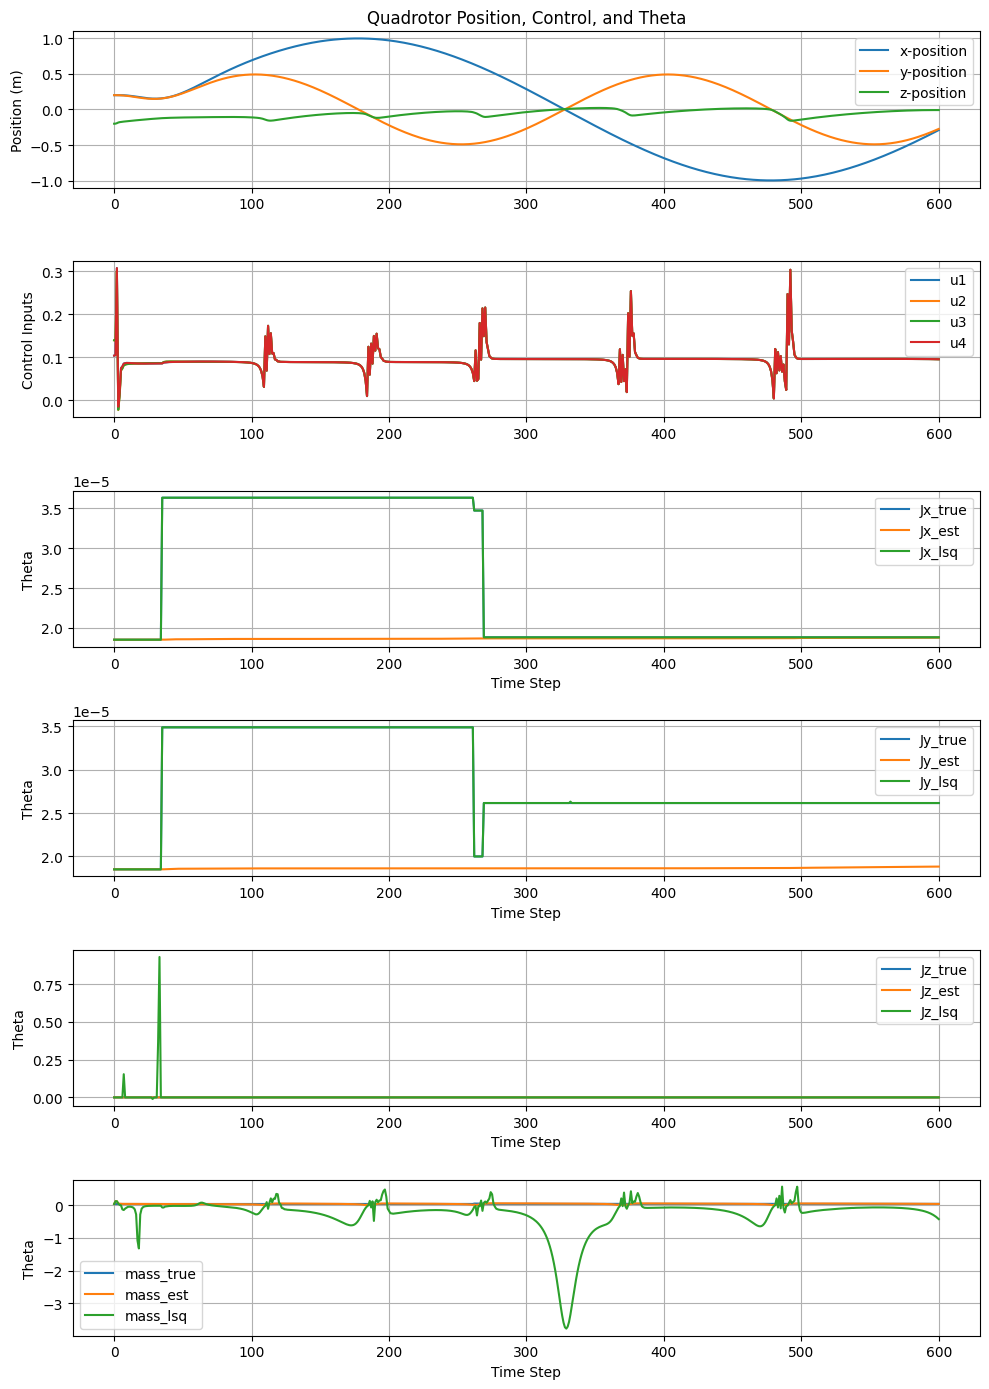

In [711]:
import matplotlib.pyplot as plt

# 1) Run your simulation
estimator = OnlineParamEst()
# x_all, u_all, theta_all, theta_hat_all,lsq_solns = estimator.simulate_quadrotor_hover_with_RLS(
#     update_status="immediate_update", 
#     NSIM=500
# )
# x_all, u_all, theta_all= estimator.simulate_quadrotor_hover_with_Naive_MPC(
#     update_status="immediate_update", 
#     NSIM=600
# )
x_all, u_all, theta_all, theta_hat_all,lsq_solns = estimator.simulate_quadrotor_tracking_with_RLS(
    update_status="immediate_update", 
    NSIM=600
)
# x_all, u_all, theta_all = estimator.simulate_quadrotor_hover_with_Naive_MPC(
#     update_status="immediate_update", 
#     NSIM=500
# )
mass,Jx,Jy,Jz = [],[],[],[]
for theta in theta_all:
    mass.append(theta[0].item())
    Jx.append(theta[1].item())
    Jy.append(theta[2].item())
    Jz.append(theta[3].item())

mass_est, Jx_est, Jy_est,Jz_est =[],[],[],[]
for theta_hat in theta_hat_all:
    mass_est.append(theta_hat[0].item())
    Jx_est.append(theta_hat[1].item())
    Jy_est.append(theta_hat[2].item())
    Jz_est.append(theta_hat[3].item())

mass_lsq, Jx_lsq, Jy_lsq,Jz_lsq =[],[],[],[]
for lsq in lsq_solns:
    mass_lsq.append(lsq[0].item())
    Jx_lsq.append(lsq[1].item())
    Jy_lsq.append(lsq[2].item())
    Jz_lsq.append(lsq[3].item())
# 2) Prepare time array (integer steps for each iteration)
time = range(len(x_all))  # 0,1,2,... up to NSIM-1

# 3) Extract position (assuming x_all[i][0:3] = (x, y, z))
pos_x = [state[0] for state in x_all]
pos_y = [state[1] for state in x_all]
pos_z = [state[2] for state in x_all]

# 4) Extract controls (assuming each control vector is length 4)
u1 = [ctrl[0] for ctrl in u_all]
u2 = [ctrl[1] for ctrl in u_all]
u3 = [ctrl[2] for ctrl in u_all]
u4 = [ctrl[3] for ctrl in u_all]




# 6) Plot everything in subplots
plt.figure(figsize=(10,14))

# --- Position ---
plt.subplot(6,1,1)
plt.plot(time, pos_x, label='x-position')
plt.plot(time, pos_y, label='y-position')
plt.plot(time, pos_z, label='z-position')
plt.title("Quadrotor Position, Control, and Theta")
plt.ylabel("Position (m)")
plt.legend()
plt.grid(True)

# --- Control ---
plt.subplot(6,1,2)
plt.plot(time, u1, label='u1')
plt.plot(time, u2, label='u2')
plt.plot(time, u3, label='u3')
plt.plot(time, u4, label='u4')
plt.ylabel("Control Inputs")
plt.legend()
plt.grid(True)

# --- Theta (mass, gravity) ---
plt.subplot(6,1,3)
plt.plot(time, Jx, label='Jx_true')
plt.plot(time, Jx_est, label='Jx_est')
plt.plot(time, Jx_lsq, label='Jx_lsq')

plt.xlabel("Time Step")
plt.ylabel("Theta")
plt.legend()
plt.grid(True)

plt.subplot(6,1,4)

plt.plot(time, Jy, label='Jy_true')
plt.plot(time, Jy_est, label='Jy_est')
plt.plot(time, Jy_lsq, label='Jy_lsq')

plt.xlabel("Time Step")
plt.ylabel("Theta")
plt.legend()
plt.grid(True)

plt.subplot(6,1,5)

plt.plot(time, Jz, label='Jz_true')
plt.plot(time, Jz_est, label='Jz_est')
plt.plot(time, Jz_lsq, label='Jz_lsq')

plt.xlabel("Time Step")
plt.ylabel("Theta")
plt.legend()
plt.grid(True)

plt.subplot(6,1,6)
plt.plot(time, mass, label='mass_true')
plt.plot(time, mass_est, label='mass_est')
plt.plot(time, mass_lsq, label='mass_lsq')



plt.xlabel("Time Step")
plt.ylabel("Theta")

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [519]:
print(mass_est)

[0.035, 0.08447797584982528, 0.035911204829286406, -0.00432090310156006, -0.0018665237312367649, -0.0009296364026586256, -0.00026308485627754596, 0.00012149926625109058, 0.0002262779169556803, 0.00014221988322188938, -1.1982371727152486e-06, -9.24472228003719e-05, -8.348533280562188e-05, -7.935174600322018e-06, 5.6860987945000406e-05, 5.929907322879168e-05, 8.44375352529846e-06, -4.404065403086279e-05, -4.904117990157551e-05, -3.8612508962726594e-06, 4.3828634601759076e-05, 4.5307271871058535e-05, -9.286808540216827e-07, -4.874585035944134e-05, -4.5140573424676454e-05, 1.2482572337294013e-05, 6.245765226932934e-05, 4.6031681465358e-05, -2.7583379459060036e-05, -8.333639888636281e-05, -4.305125540165356e-05, 6.693080545371968e-05, 0.00011637328004500223, 3.413804682327364e-05, -0.00011847830745642834, -0.0001645510958629005, 3.2769502943910895e-05, 0.00025200448675470773, 0.00021356700637771678, -7.277333569135632e-05, -0.0004173250531192894, -0.0002249317845347486, 0.000564172768853270